<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/DLCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Building Transformer Models with Attention Crash Course. Build a Neural Machine Translator in 12 Days
by Adrian Tam on January 4, 2023 in Attention
Tweet Tweet  Share
Last Updated on January 9, 2023


Transformer is a recent breakthrough in neural machine translation. Natural languages are complicated. A word in one language can be translated into multiple words in another, depending on the context. But what exactly a context is, and how you can teach the computer to understand the context was a big problem to solve. The invention of the attention mechanism solved the problem of how to encode a context into a word, or in other words, how you can present a word and its context together in a numerical vector. Transformer brings this to one level higher so that we can build a neural network for natural language translation using only the attention mechanism but no recurrent structure. This not only makes the network simpler, easier to train, and parallelizable in algorithm but also allows a more complicated language model to be built. As a result, we can see computer-translated sentences almost flawlessly.

Indeed, such a powerful deep learning model is not difficult to build. In TensorFlow and Keras, you have almost all the building blocks readily available, and training a model is only a matter of several hours. It is fun to see a transformer model built and trained. It is even more fun to see a trained model to translate sentences from one language to another.

In this crash course, you will build a transformer model in the similar design as the original research paper.

This is a big and important post. You might want to bookmark it.

Let’s get started.


Building Transformer Models with Attention (12-day Mini-Course).
Photo by Norbert Braun, some rights reserved.

Who Is This Crash-Course For?
Before you get started, let’s make sure you are in the right place.

This course is for developers who are already familiar with TensorFlow/Keras. The lessons in this course do assume a few things about you, such as:

You know how to build a custom model, including the Keras functional API
You know how to train a deep learning model in Keras
You know how to use a trained model for inference
You do NOT need to be:

A natural language processing expert
A speaker of many languages
This crash course can help you get a deeper understanding of what a transformer model is and what it can do.

This crash course assumes you have a working TensorFlow 2.10 environment installed. If you need help with your environment, you can follow the step-by-step tutorial here:

How to Set Up Your Python Environment for Machine Learning With Anaconda
Crash-Course Overview
This crash course is broken down into 12 lessons.

You could complete one lesson per day (recommended) or complete all of the lessons in one day (hardcore). It really depends on the time you have available and your level of enthusiasm.

Below is a list of the 12 lessons that will get you started and learn about the construction of a transformer model.

Lesson 01: Obtaining Data

Lesson 02: Text Normalization

Lesson 03: Vectorization and Making Datasets

Lesson 04: Positional Encoding Matrix

Lesson 05: Positional Encoding Layer

Lesson 06: Transformer Building Blocks

Lesson 07: Transformer Encoder and Decoder

Lesson 08: Building a Transformer

Lesson 09: Preparing the Transformer Model for Training

Lesson 10: Training the Transformer

Lesson 11: Inference from the Transformer Model

Lesson 12: Improving the Model
Each lesson could take you between 15 and up to 60 minutes. Take your time and complete the lessons at your own pace. Ask questions, and even post results in the comments online.

The lessons might expect you to go off and find out how to do things. This guide will give you hints, but even if you just follow the code in the lesson, you can finish a transformer model that works quite well.

# Lesson 01: Obtaining Data



As you are building a neural machine translator, you need data for training and testing. Let’s build a sentence-based English-to-French translator. There are many resources on the Internet. An example would be the user-contributed data for the flash card app Anki. You can download some data files at https://ankiweb.net/shared/decks/french. The data file would be a ZIP file containing a SQLite database file, from which you can extract the English-French sentence pairs.

However, you may find it more convenient to have a text file version, which you can find it at https://www.manythings.org/anki/. Google hosts a mirror of this file as
well, which we will be using.

In [1]:
# https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/


import pathlib

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

3423204/3423204 [==============================] - 0s 0us/step
/root/.keras/datasets/fra.txt


#Lesson 02: Text Normalization

Lesson 02: Text Normalization
Just like all NLP tasks, you need to normalize the text before you use it. French letters have accents which would be represented as Unicode characters, but such representation is not unique in Unicode. Therefore, you will convert the string into NFKC (compatibility and composition normal form).

Next, you will tokenize the sentences. Each word should be a separate token as well as each punctuation mark. However, the punctuation used in contractions such as don’t, va-t-il, or c’est are not separated from the words. Also, convert everything into lowercase in the expectation that this will reduce the number of distinct words in the vocabulary.

Normalization and tokenization can go a lot deeper, such as subword tokenization, stemming, and lemmatization. But to keep things simple, you do not do these in this project.

Starting from scratch, the code to normalize the text is below. You will use the Python module unicodedata to convert a Unicode string into NFKC normal form. Then you will use regular expression to add space around punctuation marks. Afterward, you will wrap the French sentences (i.e., the target language) with sentinels [start] and [end]. You will see the purpose of the sentinels in later lessons.

('in the summer , people go to the seaside .', '[start] en été , les gens se rendent au bord de la mer . [end]')
('my watch keeps good time .', '[start] ma montre reste précise . [end]')
('i have just eaten lunch .', '[start] je viens juste de finir de déjeuner . [end]')
('the sky was clear when i left home .', '[start] le ciel était clair lorsque je quittai mon domicile . [end]')
('i have a student visa .', "[start] j'ai un visa étudiant . [end]")

ANALYTICS

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs



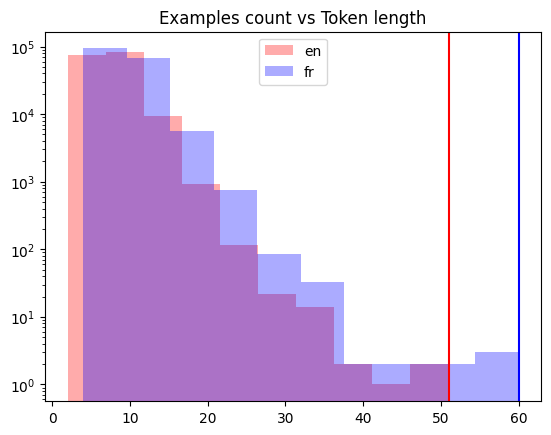

In [2]:

import pathlib
import pickle
import random
import re
import unicodedata

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)


print()
print("ANALYTICS")
print()

import pickle

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")


print()

import pickle

import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()



# Lesson 03: Vectorization and Making Datasets

In the previous lesson, you cleaned up the sentences, but they are still text. Neural networks can handle only numbers. One way to convert the text into numbers is through vectorization. What this means is to transform the tokens from the text into an integer. Hence a sentence with
 tokens (words) will become a vector of
 integers.

You can build your own vectorizer. Simply build a mapping table of each unique token to a unique integer. When it is used, you look up the token one by one in the table and return the integers in the form of a vector.

In Keras, you have TextVectorization layer to save us the effort of building a vectorizer. It supports padding, i.e., integer 0 is reserved to mean “empty.” This is useful when you give a sentence of
 tokens but want the vectorizer always to return a fixed length
 vector.

You will first split the sentence pair into training, validation, and testing sets as you need them for the model training. Then, create a TextVectorization layer and adapt it to the training set only (because you should not peek into the validation or testing dataset until the model training is completed.

In [3]:
import pickle
import random

from tensorflow.keras.layers import TextVectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

Note that the parameter max_tokens to TextVectorization object can be omitted to let the vectorizer figure it out. But if you set them to a value smaller than the total vocabulary (such as this case), you limit the the vectorizer to learn only the more frequent words and make the rare words as out-of-vocabulary (OOV). This may be useful to skip the words of little value or with spelling mistakes. You also fix the output length of the vectorizer. We assumed that a sentence should have no more than 20 tokens in the above.

The next step would be to make use of the vectorizer and create a TensorFlow Dataset object. This will be helpful in your later steps to train our model.

In [4]:

import pickle

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.

    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [   6 8689 4550   24   97 3873  104    3  117    2    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2   25 6814    6  922   53   37 9180    9    5   11  165    4    3
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [  25 6814    6  922   53   37 9180    9    5   11  165    4    3    0
    0    0    0    0    0    0]


# Lesson 04: Positional Encoding Matrix

When a sentence is vectorized, you get a vector of integers, where each integer represents a word. The integer here is only a label. We cannot assume two integers closer to each other means the words they represent are related.

In order to understand the meaning of words and hence quantify how two words are related to each other, you will use the technique word embeddings. But to understand the context, you also need to know the position of each word in a sentence. This is done by positional encoding.

In the paper Attention Is All You Need, positional encoding represents each token position with a vector. The elements of the vector are values of the different phase and frequency of sine waves. Precisely, at position
, the positional encoding vector (of length
)

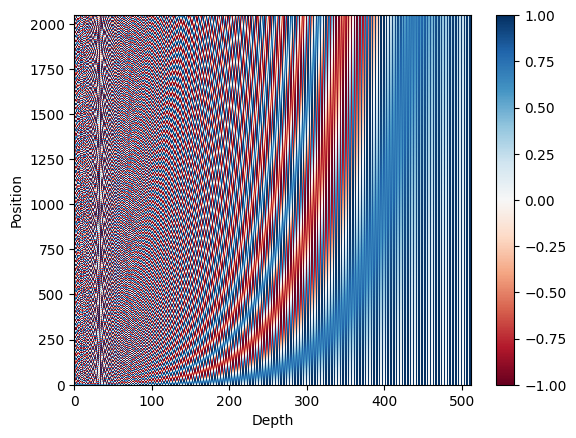

In [5]:

import pickle

import matplotlib.pyplot as plt
import numpy as np


def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P


# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)

Your task


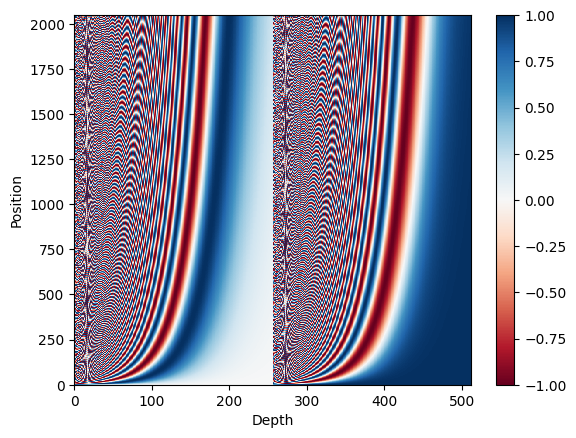

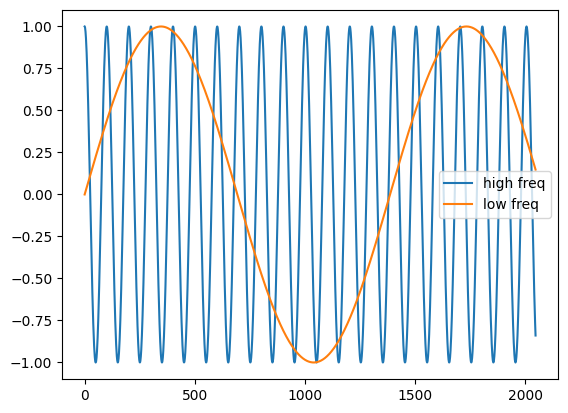

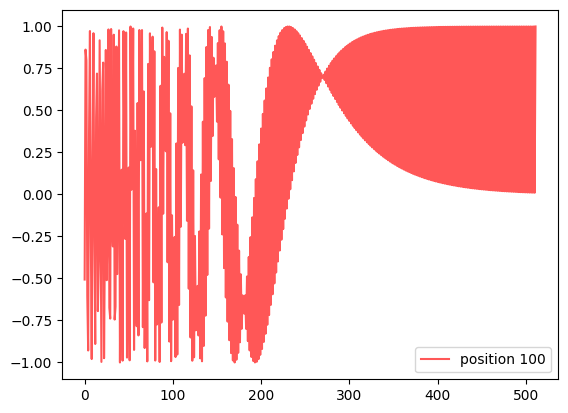

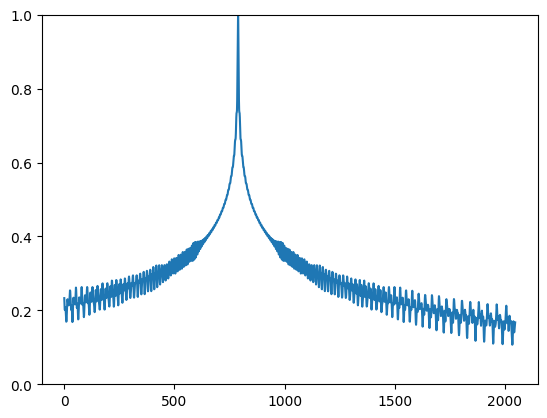

In [6]:

import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()



...
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()



import pickle
import matplotlib.pyplot as plt

with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")
plt.legend()
plt.show()


import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.plot(dots)
plt.ylim([0, 1])
plt.show()



# Lesson 05: Positional Encoding Layer

In [7]:
# https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/

import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config



# From Lesson 03:
# train_ds = make_dataset(train_pairs)

vocab_size_en = 10000
seq_length = 20

# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)


tf.Tensor(
[[  45   19   31 ...    0    0    0]
 [  39  423 3544 ...    0    0    0]
 [  32  102    8 ...    0    0    0]
 ...
 [  44  144   24 ...    0    0    0]
 [  12  209  201 ...    0    0    0]
 [  94  146  177 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


# Lesson 06: Transformer Building Blocks

Reviewing the diagram of transformer in Lesson 05, you will see that beyond the embedding and positional encoding, you have the encoder (left half of the figure) and decoder (right half of the figure). They share some similarities. Most notably, they have a multi-head attention block at the beginning and a feed forward block at the end.

It would be easier if you create each building block as separate submodels and later combine them into a bigger model.

First, you create the self-attention model. It is in the part of the diagram that is at the bottom of both encoder and decoder. A multi-head attention layer will take three inputs, namely, the key, the value, and the query. If all three inputs are the same, we call this multi-head attention layer self-attention. This submodel will have an add & norm layer with skip connection to normalize the output of the attention layer. Its implementation is as follows:

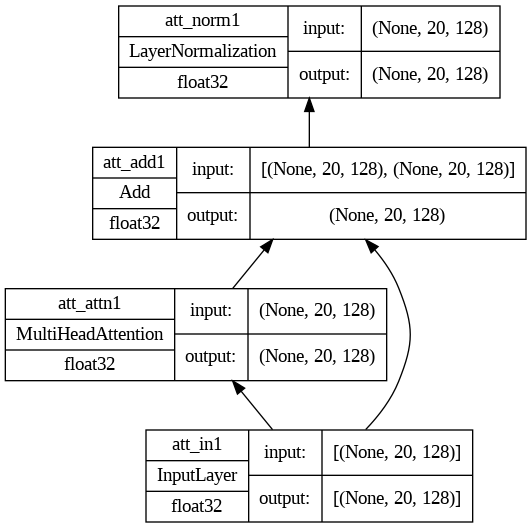

In [8]:

import tensorflow as tf

def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


In the decoder, you have a cross-attention model that takes input from the self-attention model as well as the encoder. In this case, the value and key are the output from the encoder whereas the query is the output from the self-attention model. At the high level, it is based on what the encoder understands about the context of the source sentence, and takes the partial sentence at the decoder’s input as the query (which can be empty), to predict how to complete the sentence. This is the only difference from the self-attention model; hence the code is very similar:

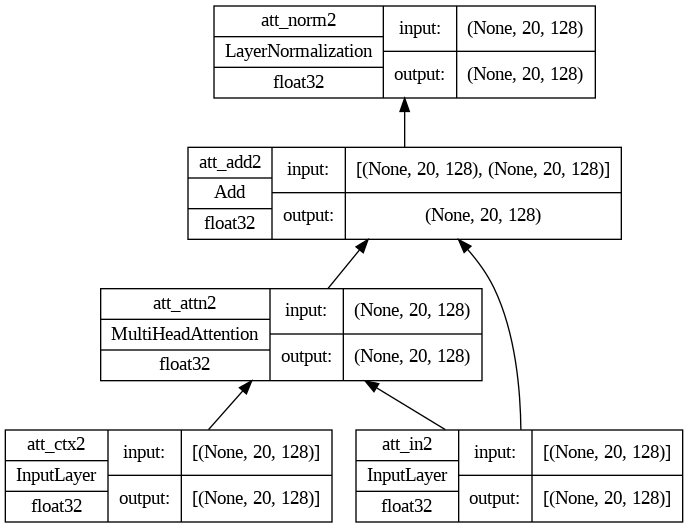

In [9]:

import tensorflow as tf

def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


Finally, there are feed forward models at the output of both encoder and decoder. It is implemented as Dense layers in Keras:

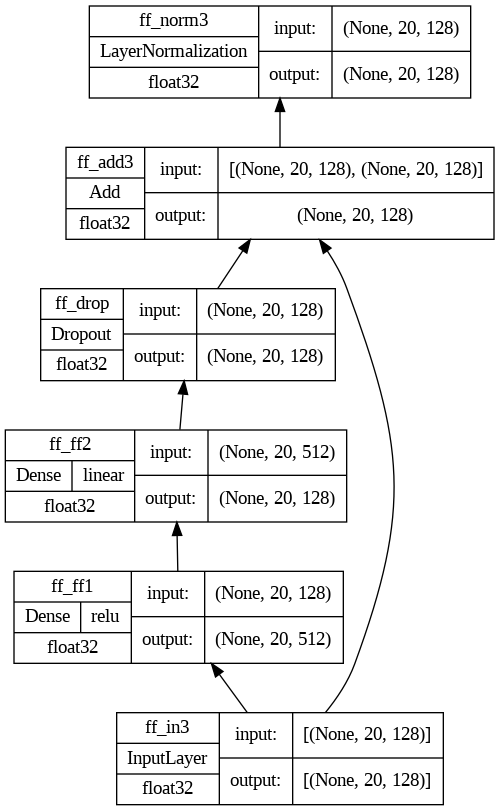

In [10]:

import tensorflow as tf

def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


# Lesson 07: Transformer Encoder and Decoder

Look again at the diagram of the transformer in Lesson 05. You will see that the encoder is the self-attention submodel connected to the feed-forward submodel. The decoder, on the other hand, is a self-attention submodel, a cross-attention submodel, and a feed-forward submodel connected in tandem.

Making an encoder and a decoder is therefore not difficult once you have these submodels as building blocks. Firstly, you have the encoder. It is simple enough that you can build an encoder model using Keras sequential API.

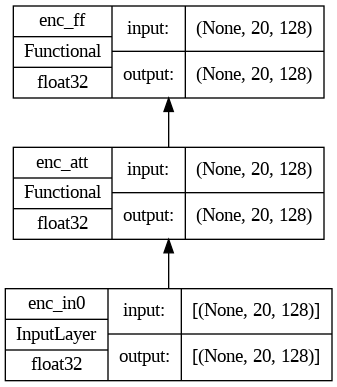

In [11]:

import tensorflow as tf

# the building block functions from Lesson 06
#from lesson_06 import self_attention, feed_forward

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


The decoder is a bit complicated because the cross-attention block takes input from the encoder as well; hence it is a model that takes two input. It is implemented as follows:

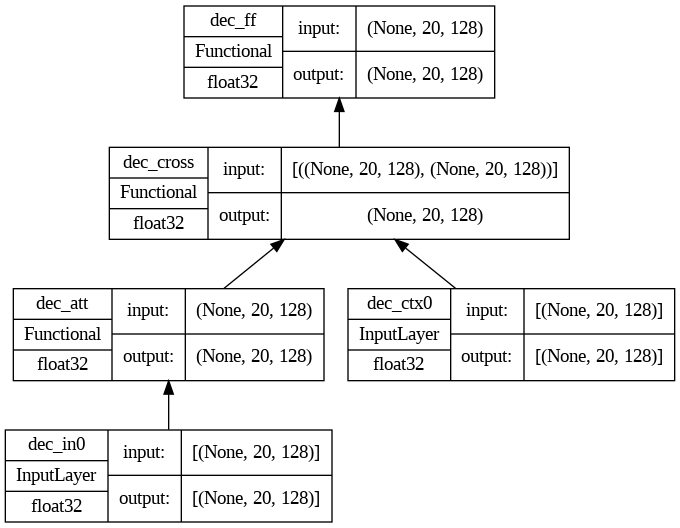

In [12]:

import tensorflow as tf

# the three building block functions from Lesson 06
#from lesson_06 import self_attention, cross_attention, feed_forward

def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


# Lesson 08: Building a Transformer

Indeed, a transformer has encoder and decoder parts, and each part is not one but a series of encoders or decoders. It sounds complicated but not if you have the building block submodels to hide the details.

Refer to the figure in Lesson 05, and you see the encoder and decoder parts are just a chain of encoder and decoder blocks. Only the output of the final encoder block is used as input to the decoder blocks.

Therefore, the complete transformer model can be built as follows:

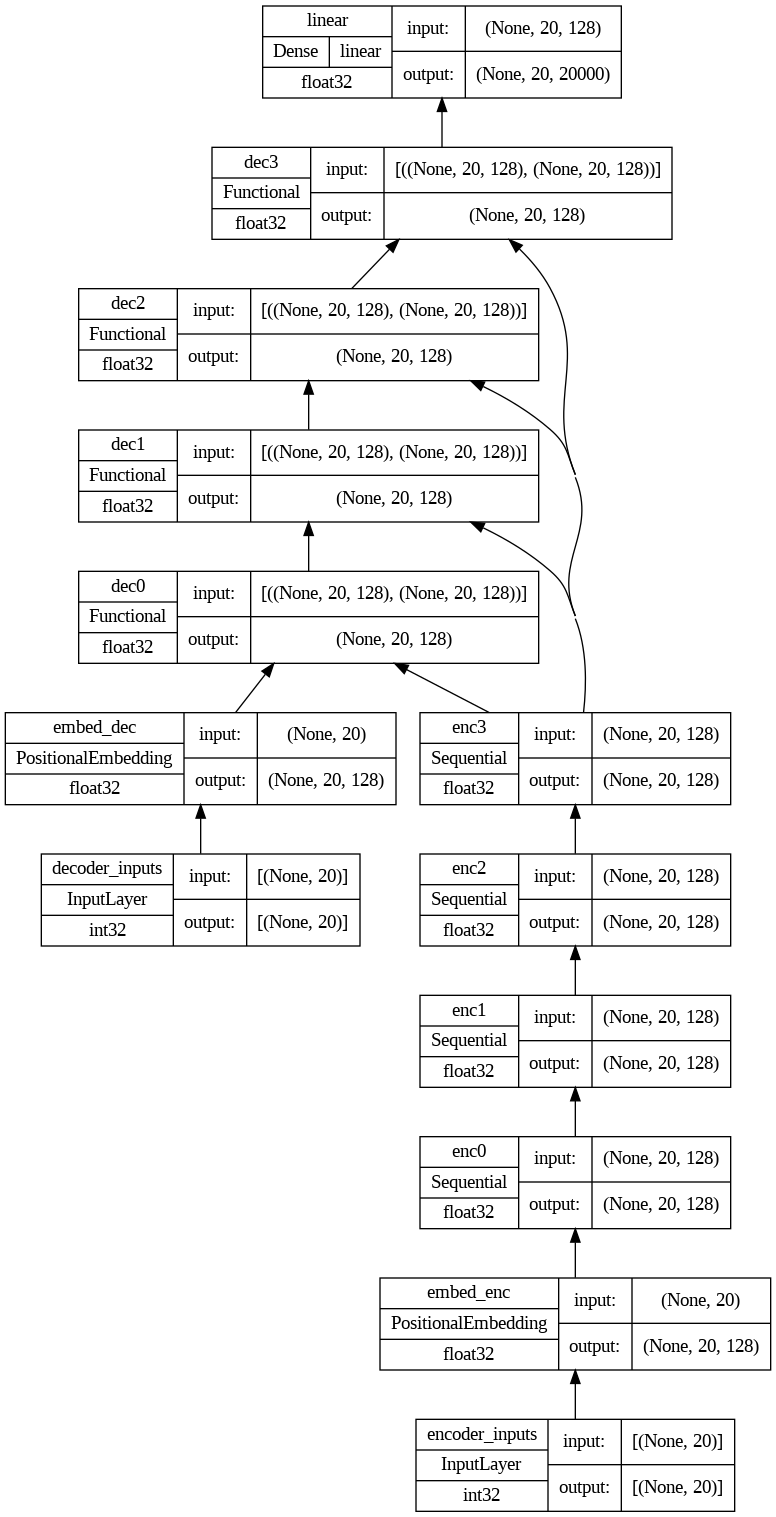

In [13]:

import tensorflow as tf

# the positional embedding layer from Lesson 05
#from lesson_05 import PositionalEmbedding
# the building block functions from Lesson 07
#from lesson_07 import encoder, decoder


def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


# Lesson 09: Prepare the Transformer Model for Training

Before you can train your transformer, you need to decide how you should train it.

According to the paper Attention Is All You Need, you are using Adam as the optimizer but with a custom learning rate schedule,





It is implemented as follows:

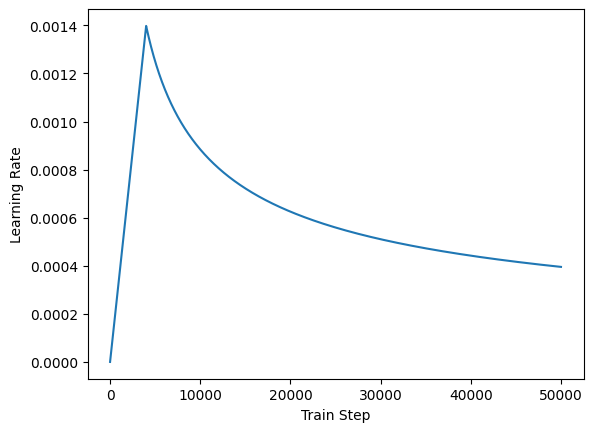

In [14]:

import matplotlib.pyplot as plt
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

Next, you also need to define the loss metric and accuracy metric for training. This model is special because you need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements. Borrow the implementation from TensorFlow’s tutorial Neural machine translation with a Transformer and Keras:

In [15]:

def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)



vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

# Lesson 10: Training the Transformer

Training the transformer depends on everything you created in all previous lessons. Most importantly, the vectorizer and dataset from Lesson 03 must be saved as they will be reused in this and the next lessons.

In [ ]:

import matplotlib.pyplot as plt
import tensorflow as tf

# the dataset objects from Lesson 03
#from lesson_03 import train_ds, val_ds
# the building block functions from Lesson 08
#from lesson_08 import transformer
# the learning rate schedule, loss, and accuracy functions from Lesson 09
#from lesson_09 import CustomSchedule, masked_loss, masked_accuracy


# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(8, 10), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()


Epoch 1/10
1828/1828 [==============================] - 265s 120ms/step - loss: 5.1997 - masked_accuracy: 0.3034 - val_loss: 3.1637 - val_masked_accuracy: 0.4696
Epoch 2/10
1828/1828 [==============================] - 186s 101ms/step - loss: 2.7111 - masked_accuracy: 0.5426 - val_loss: 2.2679 - val_masked_accuracy: 0.5990
Epoch 3/10
1828/1828 [==============================] - 185s 101ms/step - loss: 2.1098 - masked_accuracy: 0.6286 - val_loss: 1.8397 - val_masked_accuracy: 0.6668
Epoch 4/10
1828/1828 [==============================] - 185s 101ms/step - loss: 1.7650 - masked_accuracy: 0.6814 - val_loss: 1.6630 - val_masked_accuracy: 0.6971
Epoch 5/10
1828/1828 [==============================] - 185s 101ms/step - loss: 1.5903 - masked_accuracy: 0.7117 - val_loss: 1.5422 - val_masked_accuracy: 0.7162
Epoch 6/10
1828/1828 [==============================] - 185s 101ms/step - loss: 1.4675 - masked_accuracy: 0.7323 - val_loss: 1.4861 - val_masked_accuracy: 0.7263
Epoch 7/10
 615/1828 [======

# Lesson 11: Inference from the Transformer Model

In Lesson 03, you split the original dataset into training, validation, and test sets in the ratio of 70%-15%-15%. You used the training and validation dataset in the training of the transformer model in Lesson 10. And in this lesson, you are going to use the test set to see how good your trained model is.

You saved your transformer model in the previous lesson. Because you have some custom made layers and functions in the model, you need to create a custom object scope to load your saved model.

The transformer model can give you a token index. You need the vectorizer to look up the word that this index represents. You have to reuse the same vectorizer that you used in creating the dataset to maintain consistency.

Create a loop to scan the generated tokens. In other words, do not use the model to generate the entire translated sentence but consider only the next generated word in the sentence until you see the end sentinel. The first generated word would be the one generated by the start sentinel. It is the reason you processed the target sentences this way in Lesson 02.

The code is as follows:

In [ ]:

import pickle
import random

import numpy as np
import tensorflow as tf

# the dataset objects from Lesson 03
#from lesson_03 import test_pairs, eng_vectorizer, fra_vectorizer
# the positional embedding layer from Lesson 05
#from lesson_05 import PositionalEmbedding
# the learning rate schedule, loss, and accuracy functions from Lesson 09
#from lesson_09 import CustomSchedule, masked_loss, masked_accuracy


# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")

# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000

def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()


# Lesson 12: Improving the Model

You did it!

Let’s go back and review what you did and what can be improved. You made a transformer model that takes an entire English sentence and a partial French sentence (up to the
-th token) to predict the next (the
-th) token.

In training, you observed that the accuracy is at 70% to 80% at the best. How can you improve it? Here are some ideas, but surely, not exhaustive:

You used a simple tokenizer for your text input. Libraries such as NLTK can provide better tokenizers. Also, you didn’t use subword tokenization. It is less a problem for English but problematic for French. That’s why you have vastly larger vocabulary size in French in your model (e.g., l’air (the air) and d’air (of air) would become distinct tokens).
You trained your own word embeddings with an embedding layer. There are pre-trained embeddings (such as GloVe) readily available, and they usually provide better quality embeddings. This may help your model to understand the context better.
You designed the transformer with some parameters. You used 8 heads for multi-head attention, output vector dimension is 128, sentence length was limited to 20 tokens, drop out rate is 0.1, and so on. Tuning these parameters will surely impact the transformer one way or another. Similarly important are the training parameters such as number of epochs, learning rate schedule, and loss function.